In [85]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
from numba import njit

In [86]:
a=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])


In [87]:
coordinates=tspa[['x', 'y']].values

In [88]:
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)

In [89]:
costs=tspa[['val']].values

In [90]:
def plot_solution(result_list: list, coordinates: np.ndarray, weights: np.ndarray, title: str) -> None:
    plt.figure(figsize=(12, 6))
    plt.title(title)
    for i1, i2 in zip(result_list, result_list[1:] + result_list[:1]):
        point1 = coordinates[i1]
        point2 = coordinates[i2]
        plt.plot(
            [point1[0], point2[0]],
            [point1[1], point2[1]],
            c = 'black',
            zorder=1
        )

    scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=weights, cmap='inferno', s=50)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Weights')
   
    plt.show()


In [91]:
def get_random_solution(n: int) -> list[int]:
    a=np.arange(0,n)
    np.random.shuffle(a)

    return list(a[:int(np.ceil(n/2))])

In [92]:
def nn(starting_point: int, distance: np.ndarray, costs: np.ndarray) -> list[int]:
    cost_matrix=distance+costs
    cost_matrix = cost_matrix.T
    result_list=[starting_point]
    n = cost_matrix.shape[0]
    while(len(result_list) < np.ceil(n/2)):
        distances=cost_matrix[result_list[-1]]
        indices=np.arange(0,n)
        di_pairs=[(d, i) for d, i in zip(distances,indices) if i not in result_list]
        nearest_neighbor = min(di_pairs)
        result_list.append(nearest_neighbor[1])
    return result_list

In [93]:
def nn_whole_path(start_index: int, distance_matrix: np.ndarray, costs: np.ndarray) -> list[int]:
    cost_matrix=distance_matrix+costs
    cost_matrix = cost_matrix.T
    n = len(cost_matrix)
    num_nodes_to_use = n // 2
    
    path = [start_index]
    unvisited = set(range(n)) - {start_index}
    
    while len(path) < num_nodes_to_use:
        best_insertion = None
        best_distance = float('inf')
        for node in unvisited:
            for i in range(len(path) + 1):
            
            
          
                if i == 0:
                    dist_change = cost_matrix[path[0]][node]
                elif i == len(path):
                    dist_change = cost_matrix[path[-1]][node]
                else:
                    dist_change = (cost_matrix[path[i-1]][node] + 
                                   cost_matrix[node][path[i]] - 
                                   cost_matrix[path[i-1]][path[i]])
                
                if dist_change < best_distance:
               #     print('new best: ', dist_change, i, node)
                    best_distance = dist_change
                    best_insertion = (node, i)
        
        if best_insertion:
            
            node, i = best_insertion
           # print(node, i)
            path.insert(i, node)
            unvisited.remove(node)
    
    return path

In [94]:
scores_w=[]
sols_w=[]
scores_c=[]
sols_c=[]
scores_r=[]
sols_r=[]
scores_n=[]
sols_n=[]
for x in range(200):
    solution_w=nn_whole_path(x, dist, costs)
    sols_w.append(solution_w)
    scores_w.append(score(solution_w, dist, costs))
   
print('scores of nn-whole: ',min(scores_w), sum(scores_w)/len(scores_w), max(scores_w))

print(sols_w[scores_w.index(min(scores_w))])

scores of nn-whole:  44417 45870.255 53438
[40, 107, 100, 63, 122, 135, 38, 27, 16, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 162, 175, 78, 142, 45, 5, 177, 104, 8, 111, 82, 21, 61, 36, 91, 141, 77, 81, 153, 187, 163, 89, 127, 103, 113, 176, 194, 166, 86, 95, 130, 99, 22, 185, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 160, 33, 138, 11, 139, 168, 195, 145, 15, 3, 70, 13, 132, 169, 188, 6, 147, 191, 90, 51, 121]


In [45]:
def score(path: list, distance: np.ndarray, costs: np.ndarray) -> int:
    score=0
    for x in range(1,len(path)):
        score+=distance[path[x-1]][path[x]]+costs[path[x]]
   
    score+=distance[path[-1]][path[0]]+costs[path[0]]
    return int(score[0])


In [46]:
def greedy_cycle(starting_point: int, distance_matrix: np.ndarray, costs: np.ndarray) -> list:
    cost_matrix = (distance_matrix + costs).T
    n = len(distance_matrix)
    num_nodes_to_use = n // 2

    cycle = [starting_point]
    unvisited = list(range(n))
    unvisited.remove(starting_point)


    nearest = min(unvisited, key=lambda i: cost_matrix[starting_point][i])
    cycle.append(nearest)
    unvisited.remove(nearest)
    best_insertion = None
    min_increase = float('inf')

    for i in unvisited:
            increase = (
                    cost_matrix[cycle[0]][i] +
                    cost_matrix[i][cycle[1]] 
    
                )
            if increase < min_increase:
                    min_increase = increase
                    best_insertion = (i, 0)

    i, j = best_insertion
    cycle.insert(j+2, i)
    unvisited.remove(i)

    while len(cycle) < num_nodes_to_use:
        best_insertion = None
        min_increase = float('inf')
        for j in range(len(cycle)):
            for i in unvisited:
            
            
             
                k = (j + 1) % len(cycle)
                increase = (
                    cost_matrix[cycle[j]][i] + 
                    cost_matrix[i][cycle[k]] -
                    cost_matrix[cycle[j]][cycle[k]]
     
                )
                if increase < min_increase:
                    min_increase = increase
                    best_insertion = (i, k)

        i, k = best_insertion
     
        cycle.insert(k , i)
        unvisited.remove(i)

    return cycle

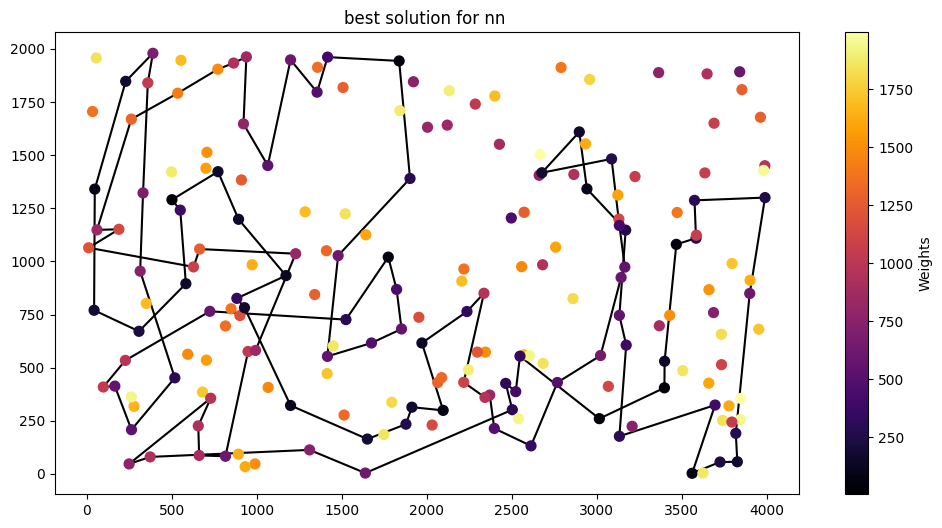

In [48]:
plot_solution(sols_n[scores_n.index(min(scores_n))], coordinates, costs, 'best solution for nn ')

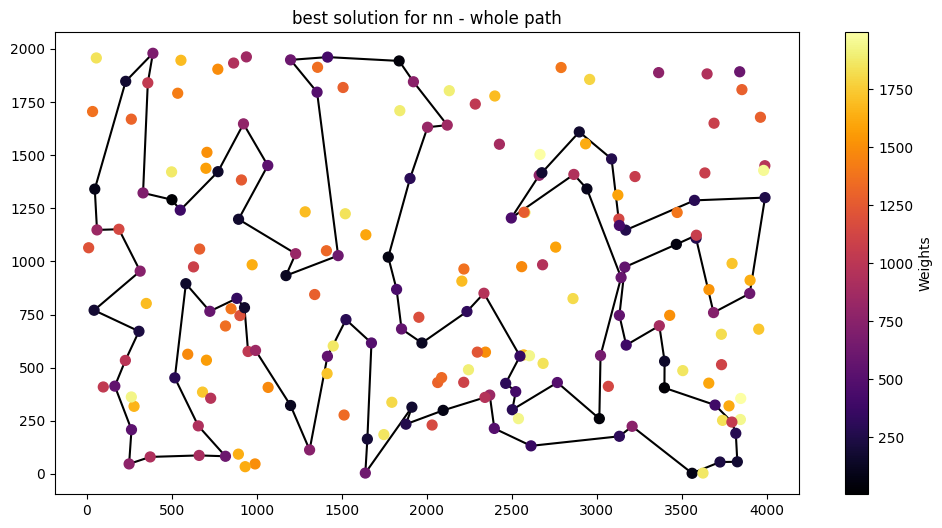

In [49]:
plot_solution(sols_w[scores_w.index(min(scores_w))], coordinates, costs, 'best solution for nn - whole path')

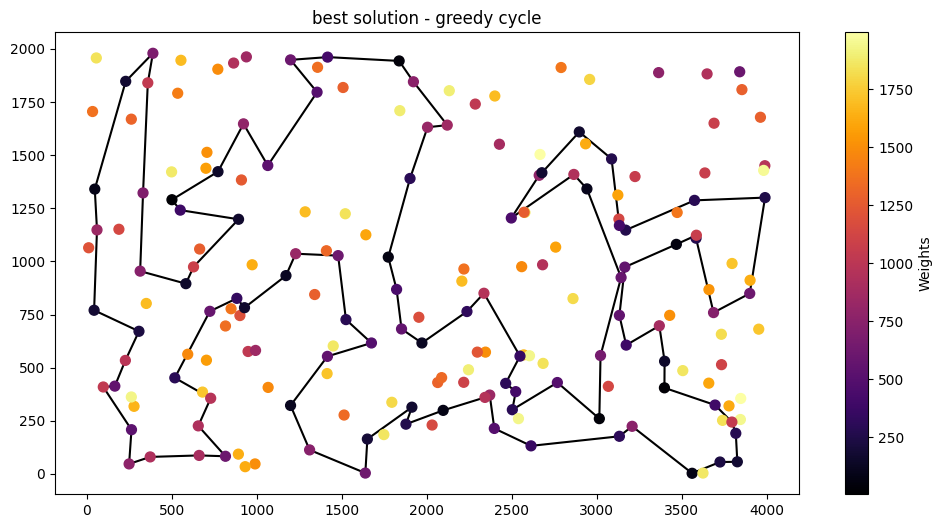

In [50]:
plot_solution(sols_c[scores_c.index(min(scores_c))], coordinates, costs, 'best solution - greedy cycle')

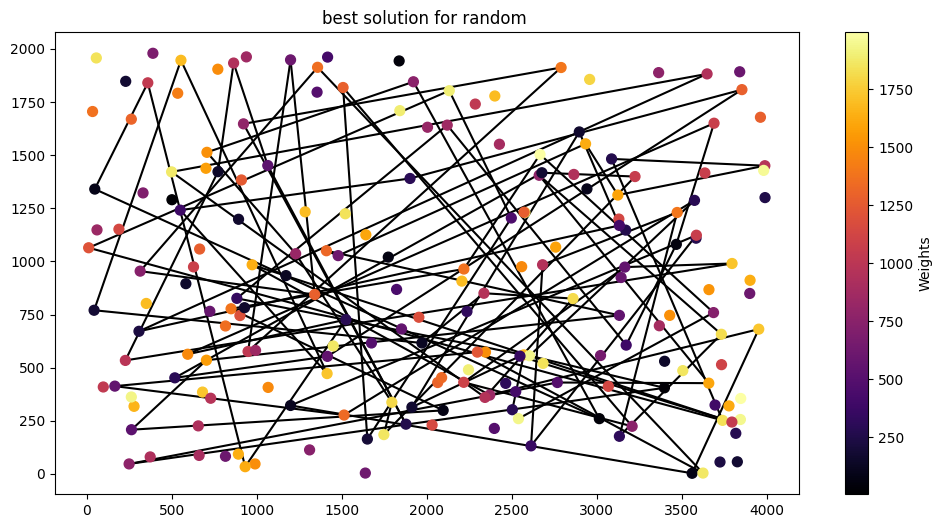

In [51]:
plot_solution(sols_r[scores_r.index(min(scores_r))], coordinates, costs, 'best solution for random ')

In [52]:
sol_w=np.array(sols_w[scores_w.index(min(scores_w))])
pd.DataFrame(sol_w).to_csv('sol_w.csv', header=False, index=False)

In [53]:
sol_n=np.array(sols_n[scores_n.index(min(scores_n))])
pd.DataFrame(sol_n).to_csv('sol_n.csv', header=False, index=False)

In [54]:
sol_r=np.array(sols_r[scores_r.index(min(scores_r))])
pd.DataFrame(sol_r).to_csv('sol_r.csv', header=False, index=False)

In [55]:
sol_c=np.array(sols_c[scores_c.index(min(scores_c))])
pd.DataFrame(sol_c).to_csv('sol_c.csv', header=False, index=False)

In [56]:
%%timeit
get_random_solution(200)

11.1 μs ± 75.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [57]:
%%timeit
nn(0, dist, costs)

15.1 ms ± 178 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
%%timeit
nn_whole_path(0, dist, costs)

566 ms ± 3.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%%timeit
greedy_cycle(0, dist, costs)

544 ms ± 7.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
